## Code based on the papers in the references of the project

### Imports

In [2]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms # Make sure this is imported
from torchvision.models.segmentation import deeplabv3_resnet50
from torchvision.models import ResNet50_Weights
from PIL import Image
import numpy as np
from tqdm import tqdm
import time
from dataset import CityscapesFineDataset, COLORS, PALETTE2ID
from torchmetrics.classification import MulticlassJaccardIndex
import matplotlib.pyplot as plt

### Globals

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"🟢 Using GPU: {torch.cuda.get_device_name(0)}") if torch.cuda.is_available() else print("🟡 Using CPU")

# Training Parameters
batch_size = 24
num_classes = 20 # 19 classes + 1 for unknown obstacles
epochs = 5
resize = (256, 512)
checkpoint_path = 'deeplabv3_cityscapes_fine.pth'
best_miou = 0.0 # To keep track of the best model based on validation mIoU

# Optimizer Parameters (from "Road Obstacle Detection based on Unknown Objectness Scores" paper inspiration)
initial_lr = 0.01
momentum = 0.9
weight_decay = 0.0001
poly_power = 0.9 # Power for the "poly" learning rate policy

# Conformal Prediction Parameters (from "A Gentle Introduction to Conformal Prediction..." paper)
alpha = 0.1 # Alpha for Conformal Prediction (1 - alpha confidence level, e.g., 0.1 for 90% coverage)

# Unknown Obstacle Detection Parameters
UNKNOWN_OBSTACLE_ID = num_classes # Using num_classes as the ID for unknown obstacles
ALL_COLORS_FOR_VISUALIZATION = COLORS.tolist() # This will pick up the updated COLORS from dataset.py
anomaly_threshold_uos = 0.01 # Threshold for anomaly detection in unknown obstacle detection

# Example image paths for inference
example_image_path = 'datasets/realcityscapes/leftImg8bit/val/frankfurt/frankfurt_000000_000294_leftImg8bit.png'
example_ground_truth_path = 'datasets/realcityscapes/gtFine/val/frankfurt/frankfurt_000000_000294_gtFine_color.png'

🟢 Using GPU: NVIDIA GeForce RTX 4070


### Utils

In [12]:
def poly_lr_scheduler(optimizer, initial_lr, current_iter, total_iter, power=0.9):
    """
    Implements the "poly" learning rate policy: lr = initial_lr * (1 - iter/total_iters)^power.
    """
    lr = initial_lr * (1 - current_iter / total_iter)**power
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

In [13]:
def decode_segmap(pred_mask, colors_list=ALL_COLORS_FOR_VISUALIZATION, ignore_id=255):
    """
    Decodes a segmentation mask (ID-based) into an RGB image using predefined colors.
    Args:
        pred_mask (np.array): Predicted segmentation mask (H, W) with class IDs.
        colors_list (list): List of RGB color tuples/lists for each class ID.
        ignore_id (int): The ID to be ignored (e.g., 255 for Cityscapes void pixels).
    Returns:
        np.array: RGB image (H, W, 3).
    """
    h, w = pred_mask.shape
    color_mask = np.zeros((h, w, 3), dtype=np.uint8)
    for label_id in np.unique(pred_mask):
        if label_id == ignore_id: # Handle ignore_index
            color_mask[pred_mask == label_id] = [0, 0, 0] # Black for ignored pixels
        elif 0 <= label_id < len(colors_list):
            color_mask[pred_mask == label_id] = colors_list[label_id]
        else:
            # Fallback for unexpected labels (shouldn't happen if UNKNOWN_OBSTACLE_ID is handled correctly)
            print(f"Warning: Unexpected label ID {label_id} found in prediction mask. Mapping to blue.")
            color_mask[pred_mask == label_id] = [0, 0, 255] # Blue for unmapped unexpected
    return color_mask

In [14]:
def rgb_to_id(rgb_mask, palette2id=PALETTE2ID, default=255):
    """
    Converts an RGB mask image to a single-channel ID mask using a palette mapping.
    Args:
        rgb_mask (np.array): RGB mask image (H, W, 3).
        palette2id (dict): Dictionary mapping RGB tuples to class IDs.
        default (int): Default ID for colors not found in the palette.
    Returns:
        np.array: Single-channel ID mask (H, W).
    """
    # Ensure rgb_mask is 3 channels
    if rgb_mask.ndim == 2: # Handle grayscale images by adding a channel
        rgb_mask = np.stack([rgb_mask]*3, axis=-1)
    
    # Create a 2D array for IDs, initialized with the default (ignore) value
    id_mask = np.full(rgb_mask.shape[:2], default, dtype=np.uint8)
    
    # Iterate through the palette and assign IDs
    for rgb_tuple, id_val in palette2id.items():
        # Find pixels that match the current RGB tuple
        matches = np.all(rgb_mask == np.array(rgb_tuple, dtype=np.uint8), axis=-1)
        id_mask[matches] = id_val
    
    return id_mask

In [15]:
def evaluate_model(model, dataloader, device, num_classes, ignore_index=255):
    """
    Evaluates the model on a given dataloader and computes the average loss and mIoU.
    """
    model.eval() # Set model to evaluation mode
    total_loss = 0.0
    
    # Initialize JaccardIndex (IoU) metric.
    metric = MulticlassJaccardIndex(num_classes=num_classes, ignore_index=ignore_index, average='macro', validate_args=False).to(device)

    with torch.no_grad(): # Disable gradient calculations for inference
        for images, masks in tqdm(dataloader, desc="Valutazione"):
            images = images.to(device, non_blocking=True)
            masks = masks.to(device, non_blocking=True)

            outputs = model(images)['out']
            # Use the global criterion (defined in Train section)
            loss = criterion(outputs, masks)
            total_loss += loss.item()

            preds = torch.argmax(outputs, dim=1) # Get predicted class for each pixel
            metric.update(preds, masks) # Update the metric with predictions and ground truth

    avg_loss = total_loss / len(dataloader)
    mean_iou = metric.compute() # Compute final mIoU across all batches

    model.train() # Set model back to training mode
    return avg_loss, mean_iou.item()

### Data

In [16]:
# Transformations for input images
transform = transforms.Compose([
    # ColorJitter is for images only, keep it here.
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(), # Convert PIL Image to Tensor
    # Normalization for ImageNet pre-trained models (DeepLabV3 uses ResNet50 backbone)
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [17]:
print("📦 Loading datasets...")

# Using CityscapesFineDataset from dataset.py
train_ds = CityscapesFineDataset(root='datasets/realcityscapes', split='train', transform=transform, resize=resize)
val_ds = CityscapesFineDataset(root='datasets/realcityscapes', split='val', transform=transform, resize=resize)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0, # Explicitly set to 0
    pin_memory=True,
    persistent_workers=False # Explicitly set to False
)

val_loader = DataLoader(
    val_ds,
    batch_size=batch_size,
    shuffle=False, # No need to shuffle validation data
    num_workers=0, # Explicitly set to 0
    pin_memory=True,
    persistent_workers=False # Explicitly set to False
)
print("✅ Datasets loaded.")

📦 Loading datasets...
✅ Datasets loaded.


### Network

In [18]:
# Initialize DeepLabV3 with ImageNet pre-trained weights for the ResNet50 backbone.
# This helps in transfer learning and often leads to faster convergence and better performance.
model = deeplabv3_resnet50(weights_backbone=ResNet50_Weights.IMAGENET1K_V1, num_classes=num_classes).to(device)
model = model.to(memory_format=torch.channels_last) # Optimize memory layout for NVIDIA GPUs

### Train

In [36]:
# Optimizer: SGD with momentum and weight decay as specified in the paper
optimizer = optim.SGD(model.parameters(), lr=initial_lr, momentum=momentum, weight_decay=weight_decay)
criterion = nn.CrossEntropyLoss(ignore_index=255) # ignore_index=255 for unlabeled pixels
scaler = torch.cuda.amp.GradScaler() # For mixed precision training

# Checkpoint Handling
start_epoch = 0
current_iteration = 0 # Initialize current_iteration for learning rate scheduler

if os.path.exists(checkpoint_path):
    ck = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(ck['model'])
    optimizer.load_state_dict(ck['optimizer'])
    scaler.load_state_dict(ck['scaler'])
    start_epoch = ck['epoch'] + 1
    if 'best_miou' in ck:
        best_miou = ck['best_miou']
    if 'current_iteration' in ck:
        current_iteration = ck['current_iteration']
    print(f"🔁 Restarting from epoch {start_epoch}, best mIoU until now: {best_miou:.4f}")
else:
    print("✨ No checkpoint found. Starting training from zero.")

C:\Users\colam\AppData\Local\Temp\ipykernel_1372\4025143161.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler() # For mixed precision training
C:\Users\colam\AppData\Local\Temp\ipykernel_1372\4025143161.py:11: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We re

🔁 Restarting from epoch 5, best mIoU until now: 0.5110


In [37]:
# Training Loop
print("🚀 Starting training...")
total_iterations = epochs * len(train_loader) # Define total_iterations here for scheduler

for epoch in range(start_epoch, start_epoch + epochs):
    start_time = time.time() # Start timer for epoch

    model.train()
    running_loss = 0
    loop = tqdm(train_loader, desc=f"Epoch {epoch+1}/{start_epoch+epochs}")
    for images, masks in loop:
        current_iteration += 1
        current_lr = poly_lr_scheduler(optimizer, initial_lr, current_iteration, total_iterations, power=poly_power)

        images = images.to(device, memory_format=torch.channels_last, non_blocking=True)
        masks = masks.to(device, non_blocking=True)
        
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            out = model(images)['out']
            loss = criterion(out, masks)
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
        loop.set_postfix(loss=running_loss/(loop.n+1), lr=f"{current_lr:.6f}") # Display current loss and LR

    train_elapsed = time.time() - start_time
    avg_train_loss = running_loss/len(train_loader)
    print(f"\nEpoch {epoch+1}/{start_epoch+epochs} - Avg Loss: {avg_train_loss:.4f} - Time: {train_elapsed:.2f} sec")

    # --- Validation during Training ---
    # `evaluate_model` is defined in the Utils section
    val_loss, val_miou = evaluate_model(model, val_loader, device, num_classes, ignore_index=255)
    print(f"Validation Loss: {val_loss:.4f}, Validation mIoU: {val_miou:.4f}")

    # --- Save Checkpoint (only if mIoU improves) ---
    if val_miou > best_miou:
        best_miou = val_miou
        torch.save({
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scaler': scaler.state_dict(),
            'epoch': epoch,
            'best_miou': best_miou,
            'current_iteration': current_iteration
        }, checkpoint_path)
        print(f"Model saved in {checkpoint_path} with improved mIoU: {best_miou:.4f}")
    else:
        print(f"No improvement in mIoU. Best current: {best_miou:.4f}")

print("\n🎉 Training completed!")

🚀 Starting training...


Epoch 6/10:   0%|          | 0/372 [00:00<?, ?it/s]C:\Users\colam\AppData\Local\Temp\ipykernel_1372\175431828.py:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Epoch 6/10:   0%|          | 0/372 [00:01<?, ?it/s]


RuntimeError: For non-complex input tensors, argument alpha must not be a complex number.

### Evaluation (in our case with inference part)

In [32]:
print("\n--- Starting Inference and Uncertainty Quantification ---")

# Load model for inference (ensure it's the same architecture as trained)
model_inf = deeplabv3_resnet50(weights_backbone=ResNet50_Weights.IMAGENET1K_V1, num_classes=num_classes).to(device)
if os.path.exists(checkpoint_path):
    checkpoint_inf = torch.load(checkpoint_path, map_location=device)
    model_inf.load_state_dict(checkpoint_inf['model'])
    print("✅ Model loaded for inference.")
else:
    print(f"❌ Checkpoint model not found in {checkpoint_path}. Impossible to proceed with inference.")
    exit() # Exit if model is not found, as subsequent steps depend on it

model_inf.eval() # Set model to evaluation mode


--- Starting Inference and Uncertainty Quantification ---


C:\Users\colam\AppData\Local\Temp\ipykernel_1372\998757462.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint_inf = torch.load(checkpoint_path, map_location=devi

✅ Model loaded for inference.


DeepLabV3(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Se

In [33]:
# --- Conformal Prediction Calibration Step (using validation set as calibration data) ---
# This step is crucial for Conformal Prediction to establish the 'q_hat' threshold.
print("\n--- Conformal Prediction: Calibration phase for Inference ---")
calibration_scores = []

with torch.no_grad():
    for images, masks in tqdm(val_loader, desc="Calibrazione"): # Use val_loader as calibration set
        images = images.to(device, non_blocking=True)
        masks = masks.to(device, non_blocking=True) # Ground truth IDs (B, H, W)

        outputs = model_inf(images)['out'] # Logits (B, C, H, W)
        
        # Resize outputs to original mask size if necessary (it should be resize already)
        outputs = torch.nn.functional.interpolate(outputs, size=masks.shape[1:], mode='bilinear', align_corners=False)
        
        probabilities = torch.softmax(outputs, dim=1) # (B, C, H, W)

        # Create a clamped version of masks for indexing.
        # Any value 255 will be replaced by 0 (or any valid class ID, e.g., 0)
        # This prevents "index out of bounds" in torch.gather.
        clamped_masks = torch.where(masks == 255, torch.tensor(0, device=device, dtype=masks.dtype), masks)
        
        # For each pixel, get the probability of the true class
        # masks has shape (B, H, W). unsqueeze(1) makes it (B, 1, H, W) for gather.
        true_class_probs = torch.gather(probabilities, 1, clamped_masks.unsqueeze(1)).squeeze(1) # (B, H, W)

        # Conformal Score: s_i = 1 - P(Y_true | X_i)
        # Filter out ignore_index (255) from scores as they are not part of the ground truth for coverage
        valid_pixels_mask = (masks != 255) # Use original masks for filtering
        pixel_scores = (1 - true_class_probs)[valid_pixels_mask] # Only consider valid pixels

        calibration_scores.extend(pixel_scores.cpu().numpy())

calibration_scores = np.sort(calibration_scores)
n_calib = len(calibration_scores)
# Calculate the quantile q_hat: ceil((n+1)(1-alpha))/n empirical quantile
# The +1 in numerator makes it non-asymptotic and valid (as per Angelopoulos et al. paper)
# The index should be 0-based
idx = int(np.ceil((n_calib + 1) * (1 - alpha))) - 1 # -1 for 0-based indexing
q_hat = calibration_scores[idx] if idx < n_calib else (calibration_scores[-1] if n_calib > 0 else 0) # Handle edge case if idx out of bounds or empty
print(f"✅ Calibration completed. Number of valid pixels for calibration: {n_calib}, q_hat: {q_hat:.4f}")



--- Conformal Prediction: Calibration phase for Inference ---


Calibrazione: 100%|██████████| 63/63 [00:45<00:00,  1.39it/s]


✅ Calibration completed. Number of valid pixels for calibration: 56501312, q_hat: 0.5959


In [34]:
# --- Perform Inference on an Example Image ---
print("\n--- Inference Execution on Sample Image ---")

# Load and preprocess example image
image = Image.open(example_image_path).convert('RGB')
ground_truth_mask_rgb = Image.open(example_ground_truth_path).convert('RGB')

# Resize images for consistency before processing
image_resized = image.resize((resize[1], resize[0]), Image.BILINEAR)
ground_truth_mask_rgb_resized = ground_truth_mask_rgb.resize((resize[1], resize[0]), Image.NEAREST)

# Convert ground truth RGB mask to ID mask for comparison/display
mapped_ground_truth_mask_id = rgb_to_id(np.array(ground_truth_mask_rgb_resized), palette2id=PALETTE2ID, default=255)
    
# Apply transformations for input image
input_tensor = transform(image_resized).unsqueeze(0).to(device)

with torch.no_grad():
    output_logits = model_inf(input_tensor)['out']
    # Ensure output matches visualization size
    output_logits = torch.nn.functional.interpolate(output_logits, size=resize, mode='bilinear', align_corners=False)
    
    probabilities = torch.softmax(output_logits, dim=1).squeeze(0) # Shape: (C, H, W)

    # 1. Predicted Segmentation (Known Classes)
    prediction_known_classes = torch.argmax(probabilities, dim=0).cpu().numpy() # Shape: (H, W)

    # --- Unknown Objectness Score (UOS) Approximation (Noguchi et al.) ---
    # Define "object" class IDs from your 19 Cityscapes classes.
    # This is based on common Cityscapes object categories (from PALETTE2ID).
    object_class_ids = [
        PALETTE2ID.get((0, 0, 142)),   # car
        PALETTE2ID.get((0, 0, 70)),    # truck
        PALETTE2ID.get((0, 60, 100)),  # bus
        PALETTE2ID.get((0, 80, 100)),  # train
        PALETTE2ID.get((0, 0, 230)),   # motorcycle
        PALETTE2ID.get((119, 11, 32)), # bicycle
        PALETTE2ID.get((220, 20, 60)), # person
        PALETTE2ID.get((255, 0, 0)),   # rider
        PALETTE2ID.get((250, 170, 30)),# traffic light
        PALETTE2ID.get((220, 220, 0))  # traffic sign
    ]
    # Filter out any IDs that might be None or out of bounds if PALETTE2ID is incomplete
    object_class_ids = [idx for idx in object_class_ids if idx is not None and 0 <= idx < num_classes]
    
    # Approximate p_O (Objectness Score): Sum of probabilities for object classes
    # probabilities shape: (num_classes, H, W)
    # Ensure object_class_ids is not empty to avoid error if no object classes are defined
    if object_class_ids:
        objectness_score = torch.sum(probabilities[object_class_ids, :, :], dim=0).cpu().numpy() # Shape: (H, W)
    else:
        objectness_score = np.zeros(probabilities.shape[1:], dtype=np.float32) # All zeros if no object classes
        print("Warning: No object class IDs defined for UOS calculation. Objectness score will be zero.")

    # Calculate the product term: Product of (1 - p_ik) for all K known classes
    product_term = torch.prod(1 - probabilities, dim=0).cpu().numpy() # Shape: (H, W)

    # Calculate Unknown Objectness Score (UOS)
    unknown_objectness_score = objectness_score * product_term
    
    combined_prediction = prediction_known_classes.copy()
    is_anomaly_pixel = (unknown_objectness_score > anomaly_threshold_uos)
    combined_prediction[is_anomaly_pixel] = UNKNOWN_OBSTACLE_ID


    # --- Conformal Prediction Sets (Varisco Heatmap - Mossina et al.) ---
    # Form pixel-wise prediction sets: C(x) = {y' | P(y'|x) >= 1 - q_hat}
    p_threshold_conformal = 1 - q_hat

    # varisco_heatmap will show the number of classes in the prediction set for each pixel
    # probabilities shape: (C, H, W)
    varisco_heatmap = torch.sum((probabilities >= p_threshold_conformal), dim=0).cpu().numpy() # Shape: (H, W)


--- Inference Execution on Sample Image ---


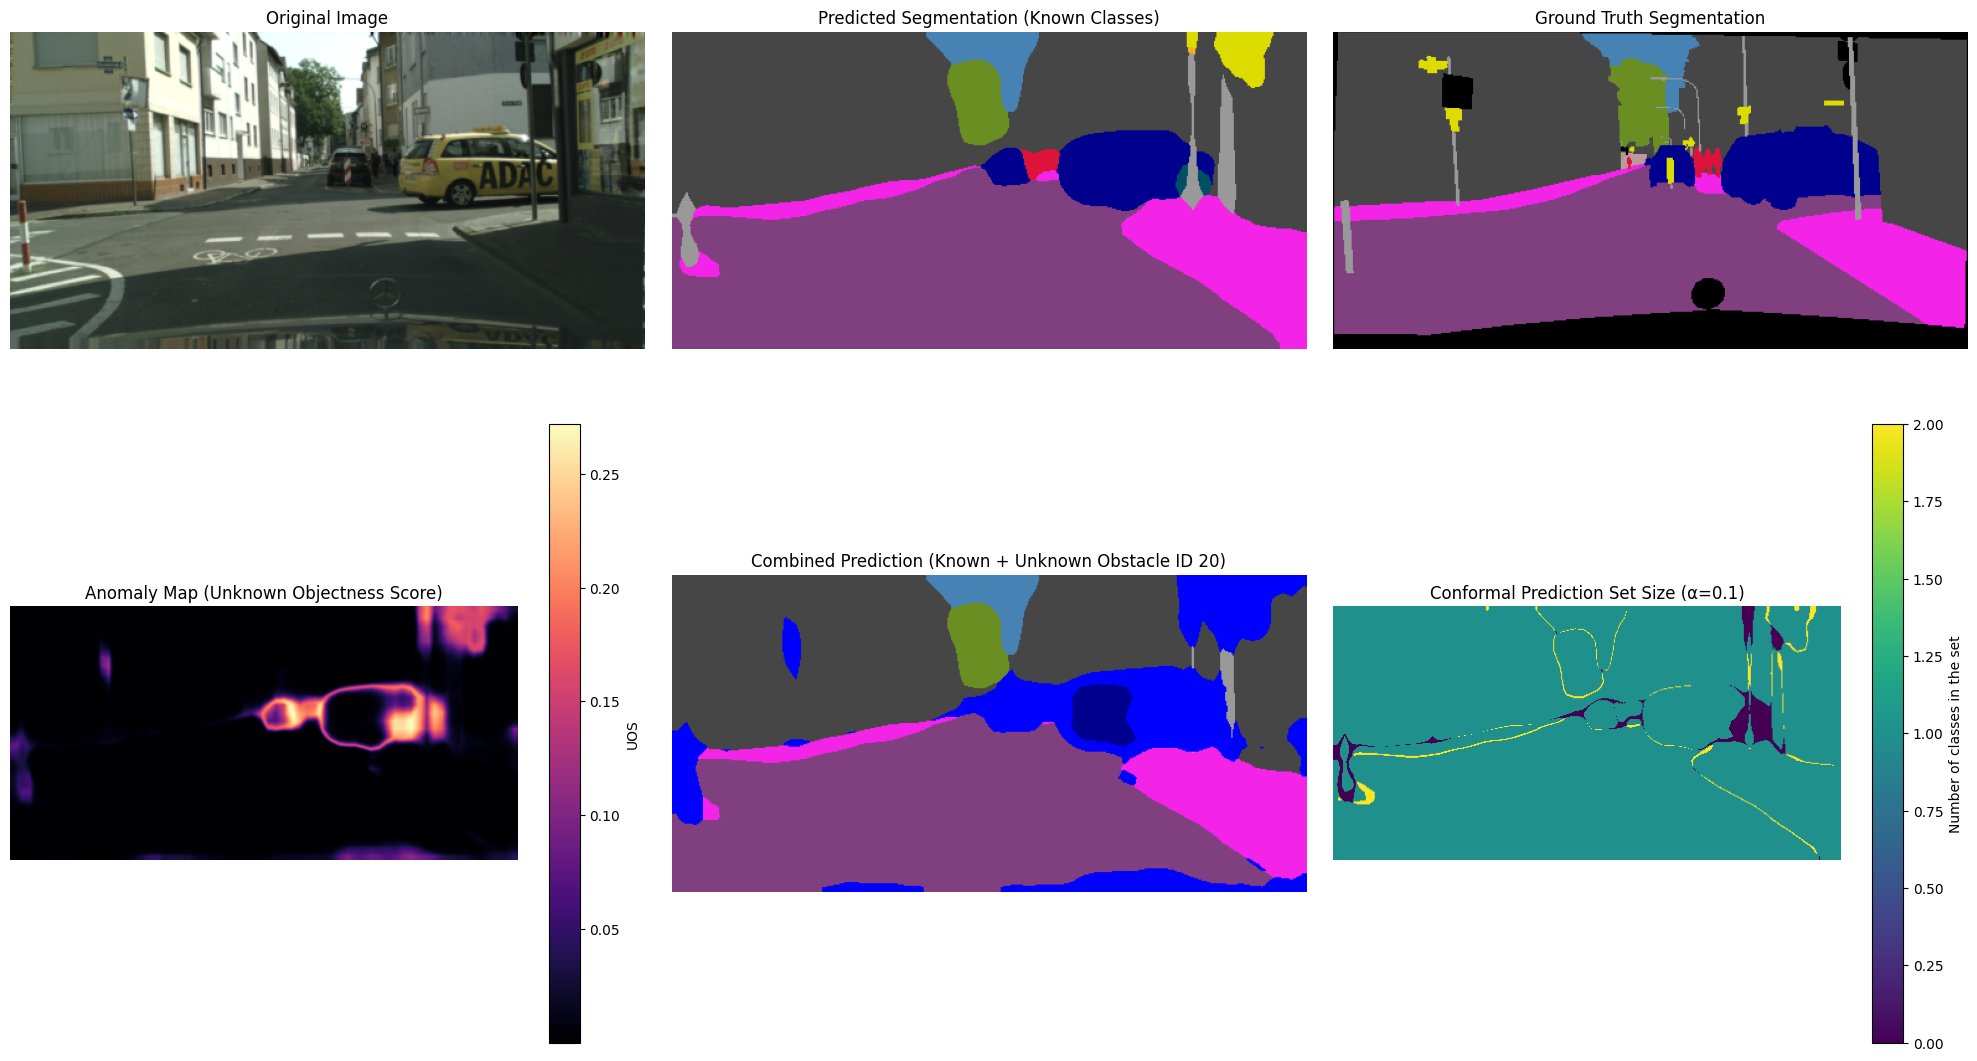


--- Analysis Completed ---


In [35]:
# --- 📊 Enhanced Visualization ---
plt.figure(figsize=(20, 12)) # Increased figure size for better display

# Original Image
plt.subplot(2, 3, 1)
plt.title("Original Image")
plt.imshow(image_resized)
plt.axis('off')

# Predicted Segmentation (Known Classes Only)
plt.subplot(2, 3, 2)
plt.title("Predicted Segmentation (Known Classes)")
seg_image_known = decode_segmap(prediction_known_classes, colors_list=ALL_COLORS_FOR_VISUALIZATION[:num_classes])
plt.imshow(seg_image_known)
plt.axis('off')

# Ground Truth Segmentation
plt.subplot(2, 3, 3)
plt.title("Ground Truth Segmentation")
# Decode GT using only known colors, as GT should not have 'unknown'
seg_image_gt = decode_segmap(mapped_ground_truth_mask_id, colors_list=ALL_COLORS_FOR_VISUALIZATION[:num_classes])
plt.imshow(seg_image_gt)
plt.axis('off')

# Anomaly Score (UOS) Map (Noguchi et al.)
plt.subplot(2, 3, 4)
plt.title("Anomaly Map (Unknown Objectness Score)")
plt.imshow(unknown_objectness_score, cmap='magma') # 'magma' or 'hot' colormap is good for showing intensity
plt.colorbar(label='UOS')
plt.axis('off')

# Combined Predicted Segmentation (Known + Unknown Obstacle)
plt.subplot(2, 3, 5)
plt.title(f"Combined Prediction (Known + Unknown Obstacle ID {UNKNOWN_OBSTACLE_ID})")
# Use ALL_COLORS_FOR_VISUALIZATION which includes the new magenta for ID 19
seg_image_combined = decode_segmap(combined_prediction, colors_list=ALL_COLORS_FOR_VISUALIZATION)
plt.imshow(seg_image_combined)
plt.axis('off')

# Conformal Prediction Set Size (Varisco Heatmap - Mossina et al.)
plt.subplot(2, 3, 6)
plt.title(f"Conformal Prediction Set Size (α={alpha})")
# Use a colormap that clearly shows varying counts, e.g., 'viridis' or 'plasma'
plt.imshow(varisco_heatmap, cmap='viridis')
plt.colorbar(label='Number of classes in the set')
plt.axis('off')

plt.tight_layout()
plt.show()

print("\n--- Analysis Completed ---")